In [35]:
# Libraries
! python -m pip install --upgrade pip

! pip install pygame
! pip install midiutil
! pip install python-ternary
! pip install anytree
! pip install graphviz
! pip install python-graphviz
! pip install image

Requirement already up-to-date: pip in c:\users\spouep\anaconda3\lib\site-packages (19.0.3)


  Could not find a version that satisfies the requirement python-graphviz (from versions: )
No matching distribution found for python-graphviz


In [80]:
#Imports
import numpy as np
from midi import *
from midiutil import MIDIFile
import matplotlib.pyplot as plt
import ternary
from ternary.helpers import simplex_iterator
import graphviz
from anytree import Node, RenderTree
from anytree.exporter import DotExporter

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [2]:
# CONSTANTS
L = 16 # length of measure
N = int(np.log2(L)+1) # Number of levels (including 0)
bpm = 400 # bpm

p1 = 0.725 # Split 2 prob
p2 = 0.275 # Play beat prob (p3 is computed automatically)
p4 = 1 # Play beat in final level; NOT MANDATORY, can be automatic if not defined 

In [3]:
# Function which chooses a rule according to the probs
def choose_rule(size, p1, p2, p4=None):
    choice = np.random.random()
    p3 = p3_from_p1p2(p1, p2)
    p4 = p4_from_p1p2(p1, p2, p4)
    
    # Not last level
    if(size != 1):
        if(choice < p1):
            return 1
        if(choice < p1+p2):
            return 2
        if(choice < p1+p2+p3):
            return 3
    
    #Final level (stop case)
    if(size == 1):
        if(choice < p4):
            return 2
        else:
            return 3 
        
def p3_from_p1p2(p1,p2):
    return 1-p1-p2

def p4_from_p1p2(p1, p2, p4=None):
    if(p4==None):
        if(p2==0 and p1==1):
            p4 = 0.5
        else:
            p4 = p2 / (1-p1)  
            
    return p4

In [48]:
# Rhythm generation
def generate_rhythm(size, volume, p1, p2, p4=None):
    rhythm = np.zeros(size)   
    
    # Recursion
    rule = choose_rule(size, p1, p2, p4)
    
    if (rule == 1):
        tree = Node("p1")
        tree.children = [
            generate_rhythm(int(size/2), volume*0.98, p1, p2, p4)[1], 
            generate_rhythm(int(size/2), volume*0.98, p1, p2, p4)[1]
        ]
        rhythm = np.append( 
            generate_rhythm(int(size/2), volume*0.98, p1, p2, p4)[0], 
            generate_rhythm(int(size/2), volume*0.98, p1, p2, p4)[0]
        )
    if (rule == 2):
        tree = Node("p2")
        rhythm[0] = volume  
    if (rule == 3):
        tree = Node("p3")

    return rhythm, tree

In [98]:
# Number of trees
def number_trees(size):
    
    if(size <= 1):
        return 2
    
    return 2 + all_trees(size/2)**2

number_trees(16)

2090918

In [85]:
# Convert a rhythm sequence into a tree of rules!
def rhythm_parser(rhythm):
    size = len(rhythm)
    np.place(rhythm, rhythm>0, 1)
    
    # p4
    if(size == 1 and rhythm[0] != 0):
        tree = Node("p4")   
    # p5
    elif(size == 1 and rhythm[0] == 0):
        tree = Node("p4")   
    # p2
    elif(rhythm[0] != 0 and np.all(rhythm[1:] == 0)):
        tree = Node("p2")
    # p3
    elif(np.all(rhythm == 0)):
        tree = Node("p3")
    # p1
    else:
        tree = Node("p1")
        tree.children = [
        rhythm_parser(rhythm[:int(size/2)]),
        rhythm_parser(rhythm[int(size/2):])]   
    
    return tree

print(RenderTree(rhythm_parser(rhythm)))

Node('/p1')
├── Node('/p1/p1')
│   ├── Node('/p1/p1/p1')
│   │   ├── Node('/p1/p1/p1/p2')
│   │   └── Node('/p1/p1/p1/p2')
│   └── Node('/p1/p1/p1')
│       ├── Node('/p1/p1/p1/p1')
│       │   ├── Node('/p1/p1/p1/p1/p4')
│       │   └── Node('/p1/p1/p1/p1/p4')
│       └── Node('/p1/p1/p1/p1')
│           ├── Node('/p1/p1/p1/p1/p4')
│           └── Node('/p1/p1/p1/p1/p4')
└── Node('/p1/p2')


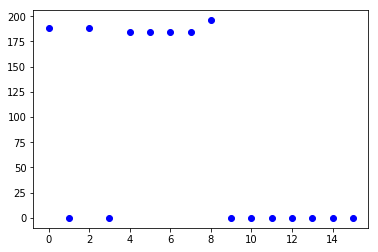

In [84]:
#Generate the audio beat and play it
rhythm = generate_rhythm(L, 200, p1, p2)[0]
plt.plot(rhythm, 'bo')
plt.show()

degree   = 60   # pitch
track    = 0
channel  = 0
time     = 1    # In beats
duration = 1    # In beats
tempo    = bpm  # In BPM
volumes  = rhythm.astype(int).tolist()  # 0-127, as per the MIDI standard
tempos   = generate_tempo(L).astype(int).tolist()

MyMIDI = MIDIFile(1)  # One track, defaults to format 1 (tempo track is created automatically)
MyMIDI.addTempo(track, time, tempo)

# Rhythm
MyMIDI.addProgramChange(tracknum=0, channel=0, time=0, program = 115)
for i, volume in enumerate(volumes):
    MyMIDI.addNote(track=0, channel=0, pitch=50, time=time + i, duration=duration, volume=volume)
    
# Tempo
MyMIDI.addProgramChange(tracknum=0, channel=1, time=0, program = 115)    
for i, tempo in enumerate(tempos):
    MyMIDI.addNote(track=0, channel=1, pitch=90, time=time + i, duration=duration, volume=tempo)

with open("test.mid", "wb") as output_file:
    MyMIDI.writeFile(output_file)

play_music("test.mid")

In [83]:
def WNBD(rhythm):
    meter = 4
    beats = np.nonzero(rhythm)[0]
    length = len(beats)
    
    T = np.zeros(length) # as in the paper
    W = np.zeros(length) # denominator weight for (finishes before meter, after meter...)
    D = np.zeros(length) # as in the paper
    
    T = np.minimum(beats % meter, -beats % meter)        
    
    for i in range(length-1): # length-1 because last beat has no next beat
        W[i] = int(beats[i+1]/4) - int(beats[i]/4) + 1
        if (W[i] > 2):
            W[i] = 1
    W[length-1] = int(len(rhythm)/4) - int(beats[length-1]/4) + 1 # last beat special case
    if (W[length-1] > 2): 
        W[length-1] = 1
    
    D = (W/T)[T !=0] # avoid div/0
    return np.sum(D)

WNBD(rhythm)

C:\Users\Spouep\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


0.0

In [68]:
# Functions for probabilities of notes to be played
def prob_to_be_played(size, level, p1, p2, p4=None):
    p4 = p4_from_p1p2(p1, p2, p4)
    acc = 0
    for i in range (int(N-level)):
        acc += p1**(i+level) * p2
    
    return p4 * p1**N + acc

vprob_to_be_played = np.vectorize(prob_to_be_played)

def levels(size):
    levels = np.zeros(size)
    
    for i in range(size):
        for j in range(N):
            if (i%(2**j) != 0):
                levels[i] += 1
                
    return levels
    
def probs_in_measure(size, p1, p2, p4=None):
    return vprob_to_be_played(size, levels(size), p1, p2, p4)

def expected_number_beats(size, p1, p2, p4=None):
    return np.sum(probs_in_measure(size, p1, p2, p4))

def variance_number_beats(size, p1, p2, p4=None):
    return np.sum(np.multiply(probs_in_measure(size, p1, p2, p4), 1 - probs_in_measure(size, p1, p2, p4)))

def probs_in_order(size, p1, p2, p4=None):
    probs = np.zeros(N)
    for i in range(N):
        probs[i] = vprob_to_be_played(size, i, p1, p2, p4)
    return probs

In [107]:
# Returns INPUTS for a Constant expected number of rhythms being played
def constant_expected_value(scale, constant, max_deviation):
    d = dict()
    for (i, j, k) in simplex_iterator(scale):
        E = expected_number_beats(L, i/scale, j/scale)
        if(constant - max_deviation <= E <= constant + max_deviation):
            d[(i, j, k)] = E
    return np.asarray(list(d.keys()))/scale

constant_expected_value(40, 6, 1)

array([[ 0.65 ,  0.35 ,  0.   ],
       [ 0.675,  0.3  ,  0.025],
       [ 0.675,  0.325,  0.   ],
       [ 0.7  ,  0.275,  0.025],
       [ 0.7  ,  0.3  ,  0.   ],
       [ 0.725,  0.225,  0.05 ],
       [ 0.725,  0.25 ,  0.025],
       [ 0.725,  0.275,  0.   ],
       [ 0.75 ,  0.2  ,  0.05 ],
       [ 0.75 ,  0.225,  0.025],
       [ 0.775,  0.15 ,  0.075],
       [ 0.775,  0.175,  0.05 ],
       [ 0.775,  0.2  ,  0.025],
       [ 0.8  ,  0.125,  0.075],
       [ 0.8  ,  0.15 ,  0.05 ],
       [ 0.825,  0.1  ,  0.075],
       [ 0.825,  0.125,  0.05 ],
       [ 0.85 ,  0.1  ,  0.05 ],
       [ 0.875,  0.075,  0.05 ],
       [ 0.9  ,  0.05 ,  0.05 ],
       [ 0.95 ,  0.025,  0.025]])

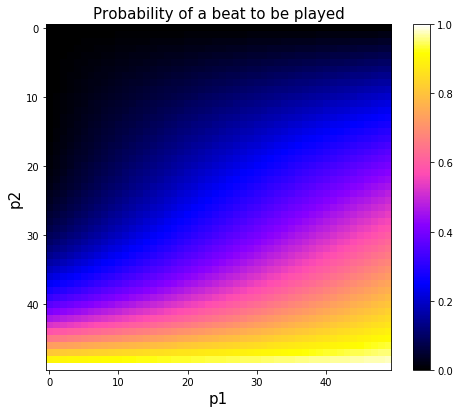

In [19]:
# [Deprecated] Grid search for square plotting
precision = 50
grid = np.zeros((precision,precision,N))

for idx, x in enumerate(np.linspace(0,1,precision)):
    for idy, y in enumerate(np.linspace(0, 1-x, precision, 0)):
        grid[idx,idy] = probs_in_order(L, x, y, 1)

# Heatmap for gridsearch
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(grid[:,:,1], interpolation='nearest', cmap=plt.cm.gnuplot2)
fontsize = 15
plt.xlabel('p1', fontsize=fontsize)
plt.ylabel('p2', fontsize=fontsize)
plt.colorbar()
plt.title('Probability of a beat to be played', fontsize=fontsize)
#plt.axis('off')
plt.savefig("graphs/grid.png", dpi=200,bbox_inches='tight')
plt.show()

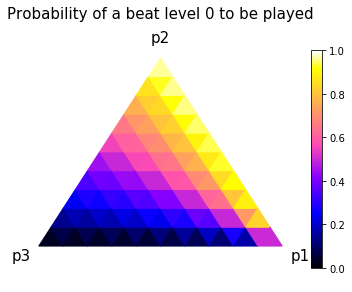

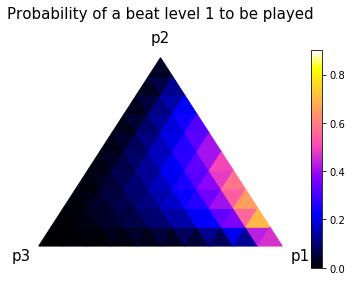

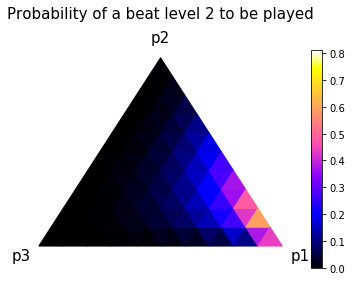

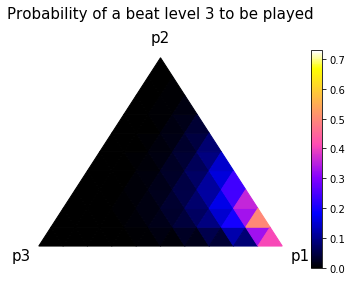

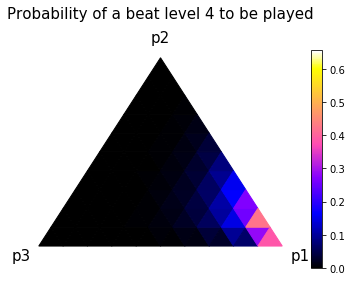

In [22]:
# Simplex search for ternary plotting
scale = 10
def generate_heatmap_data(scale=scale, level=0):
    d = dict()
    for (i, j, k) in simplex_iterator(scale):
        d[(i, j, k)] = probs_in_order(L, i/scale, j/scale)[level]
    return d

for level in range(N):
    data = generate_heatmap_data(scale, level)
    figure, tax = ternary.figure(scale=scale)
    tax.heatmap(data, style="triangular", cmap=plt.cm.gnuplot2)
    #tax.boundary()
    fontsize = 15
    tax.set_title("Probability of a beat level %s to be played" %level, fontsize=fontsize,y=1.12)
    tax.left_corner_label("p3", fontsize=fontsize)
    tax.right_corner_label("p1", fontsize=fontsize)
    tax.top_corner_label("p2", fontsize=fontsize)
    plt.axis('off')
    plt.savefig("graphs/ternary_%s.png" %level, dpi=400, bbox_inches='tight')
    plt.plot()

plt.show()

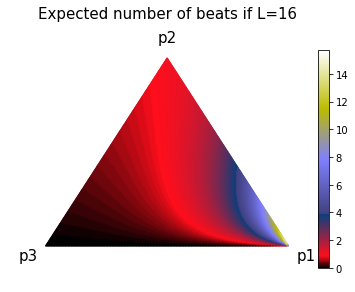

In [17]:
#Graph for expected number of beats
scale = 160
def generate_heatmap_data(scale=scale):
    d = dict()
    for (i, j, k) in simplex_iterator(scale):
        d[(i, j, k)] = expected_number_beats(L, i/scale, j/scale)
    return d

data = generate_heatmap_data(scale)
figure, tax = ternary.figure(scale=scale)
tax.heatmap(data, style="triangular", cmap=plt.cm.gist_stern)
#tax.boundary()
fontsize = 15
tax.set_title("Expected number of beats if L=%s" %L, fontsize=fontsize,y=1.12)
tax.left_corner_label("p3", fontsize=fontsize)
tax.right_corner_label("p1", fontsize=fontsize)
tax.top_corner_label("p2", fontsize=fontsize)
plt.axis('off')
plt.savefig("graphs/expected_value", dpi=400, bbox_inches='tight')
plt.plot()

plt.show()

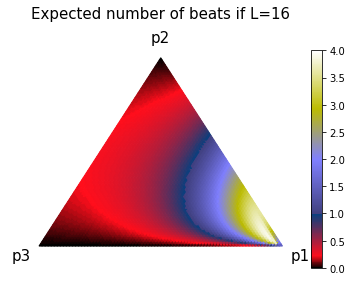

In [79]:
#Graph for variance of beats
scale = 80
def generate_heatmap_data(scale=scale):
    d = dict()
    for (i, j, k) in simplex_iterator(scale):
        d[(i, j, k)] = variance_number_beats(L, i/scale, j/scale)
    return d

data = generate_heatmap_data(scale)
figure, tax = ternary.figure(scale=scale)
tax.heatmap(data, style="triangular", cmap=plt.cm.gist_stern)
#tax.boundary()
fontsize = 15
tax.set_title("Variance in # of beats if L=%s" %L, fontsize=fontsize,y=1.12)
tax.left_corner_label("p3", fontsize=fontsize)
tax.right_corner_label("p1", fontsize=fontsize)
tax.top_corner_label("p2", fontsize=fontsize)
plt.axis('off')
plt.savefig("graphs/variance", dpi=400, bbox_inches='tight')
plt.plot()

plt.show()